# Goal:

The goal of this notebook is to create a researcher agent that uses MCPs to search the web for information.

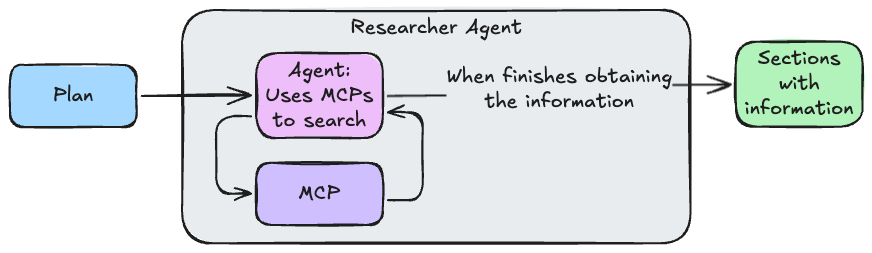

# Define Tools

We define the LLM

In [ ]:
from pydantic_settings import BaseSettings
import os

class Settings(BaseSettings):
    GOOGLE_API_KEY: str
    MODEL_NAME: str = "google-gla:gemini-2.5-flash"
    CONTEXT7_API_KEY: str
    TAVILY_API_KEY: str
    class Config:
        #ignore extra fields
        extra = "ignore"
        env_file = ".env"

settings = Settings()
os.environ["GOOGLE_API_KEY"] = settings.GOOGLE_API_KEY

# Outline from our planner agent

In [2]:
outline = """# Report Outline: Creating Agents with Pydantic-AI

## 1. Summary
*   Brief overview of AI agents and the critical role of data validation.
*   Introduction to Pydantic as a solution for robust agent development.
*   Key benefits and applications of Pydantic in various agent architectural components.

## 2. Introduction
*   **2.1. What are AI Agents?**
    *   Definition, characteristics, and common use cases (e.g., autonomous systems, chatbots, data processing agents).
    *   Components of an AI agent (perception, deliberation, action).
*   **2.2. The Growing Need for Data Validation in AI Systems**
    *   Challenges with unstructured and untrustworthy data inputs/outputs in agent interactions.
    *   Risks of invalid data (runtime errors, unexpected behavior, security vulnerabilities, incorrect decisions).
    *   Why traditional validation methods fall short in complex AI scenarios.
*   **2.3. Introducing Pydantic-AI**
    *   Brief introduction to Pydantic and its core value proposition (data parsing, validation, and settings management).
    *   Why Pydantic is a natural fit for building reliable AI agents.

## 3. Pydantic Fundamentals for Agent Creation
*   **3.1. Data Models for Agent State and Communication**
    *   **3.1.1. Defining Agent State:** Using `BaseModel` to define internal states, beliefs, and goals.
    *   **3.1.2. Input/Output Schemas:** Structuring data for agent-to-agent communication, tool calls, and LLM prompts/responses.
    *   **3.1.3. Type Hinting and Enforceability:** How Pydantic leverages Python type hints for clarity and validation.
*   **3.2. Settings Management with Pydantic BaseSettings**
    *   **3.2.1. Agent Configuration:** Managing API keys, model parameters, and other environment-dependent settings.
    *   **3.2.2. Loading from Environment Variables, .env files, etc.:** Seamless configuration loading.
*   **3.3. Validation and Error Handling**
    *   **3.3.1. Automatic Data Validation:** How Pydantic validates data upon instantiation.
    *   **3.3.2. Handling Validation Errors:** `ValidationError` and strategies for graceful error recovery in agents.
    *   **3.3.3. Customizing Error Messages:** Providing clear feedback for debugging.

## 4. Applying Pydantic in Agent Architectures
*   **4.1. Defining Tools and Action Schemas**
    *   **4.1.1. Tool Definition:** Using Pydantic models to define the input parameters and expected output of agent tools (e.g., API calls, database queries).
    *   **4.1.2. OpenAPI/JSON Schema Generation:** Leveraging Pydantic to automatically generate schemas for tool descriptions, useful for LLM integration.
    *   **4.1.3. Function Calling with LLMs:** How Pydantic schemas facilitate structured function calls from LLMs.
*   **4.2. Managing Memory and Context**
    *   **4.2.1. Structuring Conversational History:** Defining models for messages, turns, and conversation summaries.
    *   **4.2.2. Persistent Memory Storage:** Using Pydantic for serializing/deserializing agent memory components to/from databases or files.
    *   **4.2.3. Contextual Information:** Modeling external data sources or user profiles relevant to agent operations.
*   **4.3. Interacting with Large Language Models (LLMs)**
    *   **4.3.1. Prompt Engineering with Structured Outputs:** Guiding LLMs to produce Pydantic-valid JSON outputs.
    *   **4.3.2. Parsing LLM Responses:** Robustly parsing and validating LLM-generated text into structured Pydantic objects.
    *   **4.3.3. Handling Malformed LLM Outputs:** Strategies for re-prompting or error recovery when LLM outputs fail validation.

## 5. Advanced Pydantic Features for Agents
*   **5.1. Custom Validators and Root Validators**
    *   **5.1.1. Field-level Validation:** Implementing specific validation logic for individual fields.
    *   **5.1.2. Model-level (Root) Validation:** Cross-field validation for complex interdependencies within an agent's state or actions.
*   **5.2. Generics for Flexible Agent Components**
    *   **5.2.1. Building Reusable Components:** Creating generic tool interfaces, memory structures, or agent templates.
    *   **5.2.2. Adapting to Different Agent Types:** How generics allow for more adaptable and extensible agent designs.
*   **5.3. Serialization and Deserialization for Persistence**
    *   **5.3.1. `model_dump()` and `model_validate()`:** Efficiently converting agent states to and from JSON/dictionaries.
    *   **5.3.2. Saving and Loading Agent Snapshots:** Persisting agent progress, memory, and configurations.

## 6. Conclusion
*   **6.1. Recap of Benefits:** Reinforcing how Pydantic enhances agent reliability, maintainability, and development speed.
*   **6.2. Future Directions:** Potential for Pydantic in emergent agent architectures, multi-agent systems, and ethical AI development.
*   **6.3. Final Thoughts:** Encouraging the adoption of robust data validation practices in AI agent creation.

## 7. References
*   [Placeholder for academic papers, articles, official Pydantic documentation, relevant AI agent frameworks, etc.]"""

## Define Agent

We define the Agent with the Data models, MPC Server and Instructions

In [3]:
from pydantic_ai import Agent
from pydantic import BaseModel, Field
from pydantic_ai.mcp import MCPServerStreamableHTTP

tavily_server = MCPServerStreamableHTTP(
    url =f'https://mcp.tavily.com/mcp/?tavilyApiKey={settings.TAVILY_API_KEY}'
)

class Section(BaseModel):
    title: str = Field(description="The title/subtitle of the section")
    content: str = Field(description="The content of the section, that answers the title of the section")
    references: str = Field(description="The references of the section, that are used to answer the title of the section")


class documentationOutput(BaseModel):
    sections: list[Section] = Field(description="The sections of the report, that are used to answer the outline")
    

mcp_agent = Agent(settings.MODEL_NAME, toolsets=[tavily_server], 
instructions="""You are a helpful AI assistant tasked with getting content for a comprehensive report based on a given outline. Your goal is to research and compile current information for each section and subsection of the outline using the Tavily MCP server. Follow these steps to complete the task:

1. Review the provided outline

2. For each section and subsection in the outline:
   a. Use the Tavily MCP server to search for current information related to the topic.
   b. Review the search results and identify the most relevant and reliable sources.
   c. After fetching the content, analyze and summarize the information relevant to the outline section.

3. Write the report section by section, following the structure of the outline. For each section:
   a. Provide a brief introduction to the topic.
   b. Include relevant information gathered from your research.
   c. Ensure that the content is well-organized and flows logically.
   d. Use appropriate transitions between subsections and main sections.

4. Throughout the writing process, keep track of the sources you've used. For each source, note:
   - The title of the webpage or article
   - The author (if available)
   - The website name
   - The URL
   - The date you accessed the information
""",
    output_type=documentationOutput
)
# Run the Researcher Agent
async with mcp_agent:  
    nodes = []
    async with mcp_agent.iter(
        f"The outline of the report is: {outline}",
    ) as agent_run:
        async for node in agent_run:
            # Each node represents a step in the agent's execution
            print(node)
            nodes.append(node)

UserPromptNode(user_prompt="The outline of the report is: # Report Outline: Creating Agents with Pydantic-AI\n\n## 1. Summary\n*   Brief overview of AI agents and the critical role of data validation.\n*   Introduction to Pydantic as a solution for robust agent development.\n*   Key benefits and applications of Pydantic in various agent architectural components.\n\n## 2. Introduction\n*   **2.1. What are AI Agents?**\n    *   Definition, characteristics, and common use cases (e.g., autonomous systems, chatbots, data processing agents).\n    *   Components of an AI agent (perception, deliberation, action).\n*   **2.2. The Growing Need for Data Validation in AI Systems**\n    *   Challenges with unstructured and untrustworthy data inputs/outputs in agent interactions.\n    *   Risks of invalid data (runtime errors, unexpected behavior, security vulnerabilities, incorrect decisions).\n    *   Why traditional validation methods fall short in complex AI scenarios.\n*   **2.3. Introducing Py

# Display Results

In [4]:
print(nodes[-1].data.output.model_dump_json(indent=4))

{
    "sections": [
        {
            "title": "1. Summary",
            "content": "AI agents are becoming increasingly sophisticated, automating complex tasks and interacting with diverse data sources. However, the reliability and predictability of these agents heavily depend on the quality and structure of the data they process. This necessitates robust data validation mechanisms to prevent runtime errors, ensure consistent behavior, and mitigate security risks. Pydantic-AI emerges as a powerful solution in this landscape, providing a framework built on the highly regarded Pydantic library for developing production-grade AI agents.\n\nPydantic's core value proposition lies in its ability to parse and validate data using Python type hints, ensuring that inputs and outputs conform to predefined schemas. In the context of AI agent development, Pydantic-AI leverages this capability to streamline the creation of agents that are reliable, maintainable, and efficient. Key benefits incl

## Conclusion

In this notebook, we demonstrated how to create a **Researcher Agent** that transforms plans into comprehensive, well-researched content:

### Key Takeaways

1. **Plan-to-Content Pipeline**: Built an agent that takes a structured outline and systematically researches each section to create detailed content
2. **Web Research Integration**: Used Tavily MCP server to perform real-time web searches and gather current information
3. **Structured Content Generation**: Defined comprehensive Pydantic models (`Section`, `documentationOutput`) to ensure consistent, well-organized output
4. **Systematic Research Process**: Implemented a methodical approach where the agent searches, analyzes, and synthesizes information for each outline section
5. **Source Tracking**: Built-in reference management to track and cite sources used in the research process

### What We Learned

- **Research Automation**: Agents can autonomously conduct systematic research following a predefined structure
- **Information Synthesis**: AI agents can effectively gather, analyze, and synthesize information from multiple web sources
- **Structured Documentation**: Pydantic models ensure that research outputs are consistently formatted and include proper citations
- **Agent Specialization**: Research agents excel at focused, systematic information gathering tasks
- **Quality Control**: The agent follows specific instructions to prioritize reliable sources and maintain research quality

### The Research Process Demonstrated

1. **Outline Analysis**: Agent reviews the provided plan/outline to understand research requirements
2. **Systematic Search**: For each section, performs targeted web searches using relevant keywords
3. **Source Evaluation**: Reviews search results to identify reliable and relevant sources
4. **Content Synthesis**: Analyzes and summarizes information to create coherent section content
5. **Reference Management**: Tracks and properly cites all sources used in the research

### Agent Workflow Integration

This researcher agent perfectly complements the planner agent from the previous notebook:
- **Planner Agent**: Creates structured outlines and research plans
- **Researcher Agent**: Executes the research plan and generates detailed content

This demonstrates how specialized agents can work together in a pipeline to accomplish complex, multi-stage tasks - from planning to execution to content creation.
